This notebook will be used to build your simulation.

In [1]:
import sys
sys.path.append('..')
sys.path.append('../Modules')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(os.getcwd())
if 'notebook' in os.getcwd():
    # os.chdir("../scripts") # go from Neural-Modeling/notebooks to Neural-Modeling/scripts, where simulation outputs will be generated to. (maybe a separate folder could be used...)
    os.chdir("../simulations") # go to output folder
    print(os.getcwd())

/home/drfrbc/Neural-Modeling/notebooks
/home/drfrbc/Neural-Modeling/simulations


## User Specifications -  parameters, simulation folder

In [2]:
from Modules.constants import HayParameters
import datetime
import pickle
from neuron import h

from Modules.simulation_slurm import Simulator

from scripts.gen_param_list_advanced import sim_type_params_all, morphologies

# this is a quick example, but the advanced generation of parameter sets and titles for parametric study is in scripts/gen_param_list_advanced.py

sim_set_title= "baseline_no_clusters"# "name_of_simulation_set"
sim_titles =  ["reduced_branches"] #["name_of_simulation1_within_set"] # for multiple: ["description_of_simulation1_within_set", "description_of_simulation2_within_set"],
sim_type = 'sta' # select simulation type
morphology = 'ReduceBranches'
morph_params = morphologies[morphology].copy()
if 'base_sim_name' in morph_params.keys(): #TODO: assemble sim_name using base_sim_name as in scripts/gen_params_list_advanced.py
    morph_params.pop('base_sim_name') # for now remove it since it is not actually an argument for HayParameters and just used for generating simulation name in scripts/gen_params_list_advanced.py
parameter_sets = [HayParameters(sim_title,
                                all_synapses_off=True, 
                                exc_clustering={},
                                **morph_params,
                                **sim_type_params_all[sim_type],
                                )
                                for sim_title in sim_titles] # no variation between simulations with this code snippet
# initialize with all_synapses_off for saving segments.csv without building synapses. # TODO: adjust saving of segments.csv to not require this. Also requires removing previous built-in synapse building implementation from cell_builder.py.

simulator = Simulator(
                        sim_set_title = sim_set_title,
                        sim_titles = sim_titles,
                        parameter_sets = parameter_sets)

# create simulation folders and save parameters in them
simulator.create_simulation_folders()

# @TODO: modularize gen_param_list_advanced.py so it can optionally be used here.
# @TODO: compile modfiles once in Simulator.__init__ if not already compiled. would need to specify them.
# @TODO: implement running accompanying functions on all sims within the simulator object in parallel or loop.

--No graphics will be displayed.


Mod files loaded successfully


In [3]:
sim_type_params_all[sim_type]

{'h_tstop': 15000,
 'merge_synapses': False,
 'record_ecp': False,
 'record_all_channels': True,
 'record_all_synapses': True}

In [4]:
simulator.sims_dir

'2025-05-23-15-58-baseline_no_clusters'

In [5]:
sim_dir = os.path.join(simulator.sims_dir, simulator.sim_titles[0]) # choose first simulation directory for the example.
os.path.abspath(sim_dir) # for copying over

'/home/drfrbc/Neural-Modeling/simulations/2025-05-23-15-58-baseline_no_clusters/reduced_branches'

## Generate segments.csv

In [6]:
from Modules.segments_file import generate_segments_csv

simulator.run_on_all_sims(simulator.sims_dir, generate_segments_csv) # generate the segments csv for each simulation

Removing duplicate coordinate at index 1 in section L5PCtemplate[0].apic[0]
getting segments of types: ['distal_basal' 'nexus' 'oblique' 'perisomatic' 'trunk' 'tuft'] for synapses


## Visualize Cell and section typing precision

Plotting tuft:


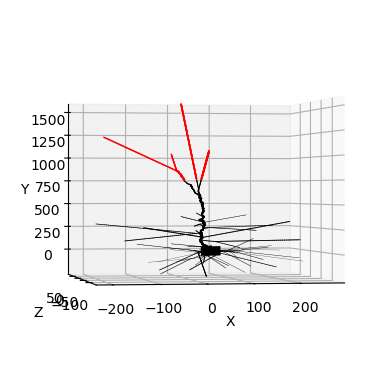

Plotting nexus:


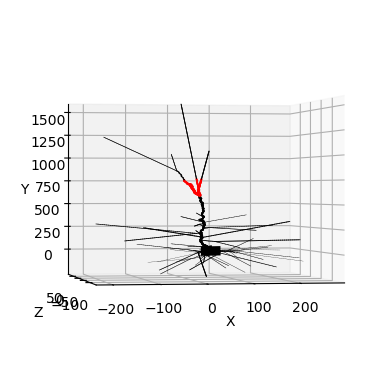

Plotting trunk:


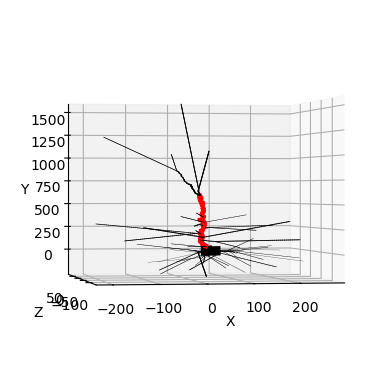

Plotting oblique:


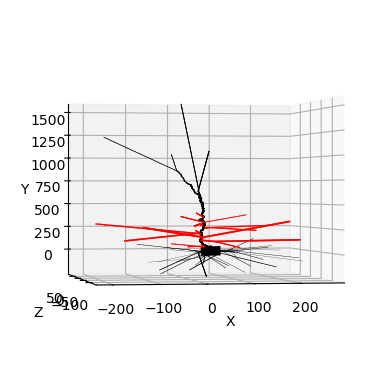

Plotting distal_basal:


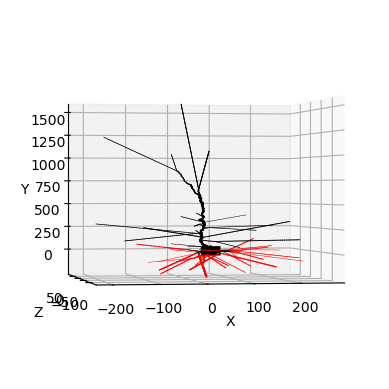

Plotting perisomatic:


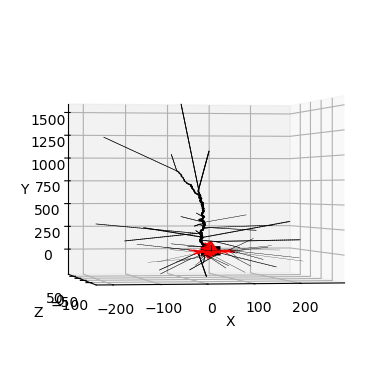

In [7]:
# # for visualizing the cell
# # also for debugging sec_type_precise generation by viewing selected segments
from Modules.plot_morphology import plot_morphology_with_highlighted_sec_type
import Modules.analysis as analysis
# sim_dir = os.path.join(simulator.sims_dir, simulator.sim_titles[0])


parameters = analysis.DataReader.load_parameters(sim_dir) # load parameters
# with open(os.path.join(sim_dir, "parameters.pickle"), "rb") as f: # load parameters
#                 parameters = pickle.load(f)

seg_data = pd.read_csv(os.path.join(sim_dir, "segment_data.csv"))


os.makedirs(os.path.join(sim_dir, "morphology"), exist_ok=True)
for sec_type in parameters.inh_syn_properties.keys(): # get list of section types
    print(f"Plotting {sec_type}:")
    fig, ax = plot_morphology_with_highlighted_sec_type(sec_type=sec_type, seg_data=seg_data)
    ax.set_title(sec_type) # TODO: not working for some reason
    fig.tight_layout()
    plt.show()
    fig.savefig(os.path.join(sim_dir, "morphology", f"{sec_type}.png"))


# ### OVERLAPPING PRECISE SEC TYPE LABELS TODO: (pull from generate_segments_csv)
# # overlapping_seg_ids = [i for i,j in overlaps.items()]


################################
# highlight multiple section types (Figure for AST)
################################
seg_data = pd.read_csv(os.path.join(sim_dir, "segment_data.csv"))

# from Modules.plot_morphology import plot_morphology_with_highlighted_sec_types
# sec_types = ['perisomatic', 'distal_basal', 'distal_apical']
# fig, ax = plot_morphology_with_highlighted_sec_types(sec_types, seg_data, figsize=(10, 6))

################################
# highlight y_range in morphology (high Ca2+)
################################
from Modules.plot_morphology import plot_morphology_with_y_range
# Basic usage with default y-range (685-885)
# fig, ax = plot_morphology_with_y_range(seg_data)

# # Custom y-range
# fig, ax = plot_morphology_with_y_range(seg_data, y_min=700, y_max=800)

# # Save to file
# fig, ax = plot_morphology_with_y_range(seg_data, save_path='y_range_highlight.png')

######### plot nexus ###########
######### plot nexus ###########
######### plot nexus ###########
# sec_type = 'nexus'
# fig, ax = plot_morphology_with_highlighted_sec_type(sec_type, seg_data)
# ax.set_title(sec_type) # TODO: not working for some reason
# fig.tight_layout()
# plt.show()
# # fig.savefig(os.path.join(sim_dir, "morphology", f"{sec_type}.png"))

## Generate Synapses.csv

In [8]:
# generate synapse objects abstractly. store info in csv.
from Modules.synapses_file import PreSimSynapseGenerator
from functools import partial

def use_pssg(sim_dir: str,  pssg_function_name):
    # create PreSimSynapseGenerator instance
    pssg = PreSimSynapseGenerator(sim_dir)
    getattr(pssg, pssg_function_name)()
    pssg.synapses.to_csv(os.path.join(sim_dir, "synapses.csv"), index=False)
    # return pssg 

# create PreSimSynapseGenerator instance
pssg = PreSimSynapseGenerator(sim_dir)
pssg.generate_synapse_locations()
pssg.synapses.to_csv(os.path.join(sim_dir, "synapses.csv"), index=False)
# return pssg 

# simulator.run_on_all_sims(simulator.sims_dir, use_pssg)

NEURON: The user defined name already exists: AMPA_NMDA
 near line 0
 {gCa_HVAbar_Ca_HVA(1.0000000000) = 0.0000555000}
                                                 ^
        nrn_load_dll("../scripts...")


In [9]:
# # view synapses from synapses csv
synapses = pd.read_csv(os.path.join(sim_dir, "synapses.csv"))
# synapses # show the synapses

In [10]:
segments = pd.read_csv(os.path.join(sim_dir, "segment_data.csv"))
# segments # show the segments

## Add spike trains to synapses.csv

In [11]:
# adds column spike_train according to parameters.
pssg.generate_spike_trains_for_synapses()
# simulator.run_on_all_sims(simulator.sims_dir, use_pssg, pssg_function_name= 'generate_spike_trains_for_synapses') #TODO: fix

In [12]:
# # view update to include spike_train column in snyapses csv
# synapses = pd.read_csv(os.path.join(sim_dir, "synapses.csv"))
# synapses # show the csv

## Analyze Designed Synapses

Cluster locations

In [13]:
# TODO: move to synapse_analysis.py
# # Import necessary modules
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from Modules.plot_morphology import plot_clusters
# import os
# import pickle

# # Load parameters and data
# # sim_dir = "path_to_your_simulation_directory"  # Replace with your actual simulation directory
# with open(os.path.join(sim_dir, "parameters.pickle"), 'rb') as file:
#     parameters = pickle.load(file)

# # Load segment data
# seg_data = pd.read_csv(os.path.join(sim_dir, "segment_data.csv"))

# # # Load synapse data if available
# synapses_with_seg_info = synapses.merge( # TODO: alternative could be used to save memory.
#     segments, 
#     on='seg_id', 
#     how='left',               # carry along all synapses even if a seg_id is missing
#     suffixes=('','_seg')      # e.g. if both have a 'length' column
# )

# columns = ['pc_0', 'pc_1', 'pc_2']

# # get the coordinates of the synapses
# synapse_coords = synapses_with_seg_info[columns].values

# # Create figure with multiple subplots for different section types
# fig = plt.figure(figsize=(20, 10))

# # Plot excitatory clusters
# ax1 = fig.add_subplot(121, projection='3d')
# plot_clusters(
#     seg_data=seg_data,
#     clustering_config=parameters.exc_clustering,
#     synapse_coords=synapse_coords,
#     ax=ax1,
#     elevation=20,
#     azimuth=-100,
#     title='Excitatory Clusters'
# )

# # Plot inhibitory clusters
# ax2 = fig.add_subplot(122, projection='3d')
# plot_clusters(
#     seg_data=seg_data,
#     clustering_config=parameters.inh_clustering,
#     synapse_coords=synapse_coords,
#     ax=ax2,
#     elevation=20,
#     azimuth=-100,
#     title='Inhibitory Clusters'
# )

# plt.tight_layout()
# plt.show()

# # Optional: Plot individual section types separately
# for sec_type in parameters.exc_clustering.keys():
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
#     plot_clusters(
#         seg_data=seg_data,
#         clustering_config={sec_type: parameters.exc_clustering[sec_type]},
#         synapse_coords=synapse_coords,
#         ax=ax,
#         elevation=20,
#         azimuth=-100,
#         title=f'Excitatory Clusters - {sec_type}'
#     )
#     plt.tight_layout()
#     plt.show()

# for sec_type in parameters.inh_clustering.keys():
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
#     plot_clusters(
#         seg_data=seg_data,
#         clustering_config={sec_type: parameters.inh_clustering[sec_type]},
#         synapse_coords=synapse_coords,
#         ax=ax,
#         elevation=20,
#         azimuth=-100,
#         title=f'Inhibitory Clusters - {sec_type}'
#     )
#     plt.tight_layout()
#     plt.show()

Spike raster, etc.

In [14]:
# from Modules.synapse_analysis import SynapseAnalyzer

#     # Generate synapse locations and spike trains for excitatory synapses
# # Initialize the analyzer with your simulation directory
# analyzer = SynapseAnalyzer(sim_dir)
# analyzer.add_segment_data()

# # Generate a spike raster plot for excitatory synapses
# analyzer.plot_spike_raster(
#     synapse_types=['exc'],
#     time_window=(0, 1000),  # First second of simulation
#     save_path=os.path.join(sim_dir, 'spike_raster.png')
# )

# # Get statistics for a specific functional group
# stats = analyzer.analyze_cluster_statistics(
#     functional_group_id=0,
#     synapse_type='exc'
# )
# print(stats)

# # Plot the spatial distribution of synapses
# analyzer.plot_cluster_spatial_distribution(
#     synapse_type='exc',
#     save_path=os.path.join(sim_dir, 'spatial_distribution.png')
# )

# # Analyze correlations between spike trains
# analyzer.plot_correlation_matrix(
#     synapse_type='exc',
#     time_window=(0, 1000),
#     save_path=os.path.join(sim_dir, 'correlation_matrix.png')
# )

In [15]:
#TODO: use function that add segment data to synapses.csv via seg_id to fix above error. (should be done in SynapseAnalyzer)

In [16]:
os.path.abspath(sim_dir) # for copying over

'/home/drfrbc/Neural-Modeling/simulations/2025-05-23-15-58-baseline_no_clusters/reduced_branches'